In [1]:
import mne
mne.set_log_level('error')
import matplotlib
import matplotlib.pyplot as plt
from functions import *
#tplotlib.use('TkAgg')

Could not load PyEMD


### Loading the data

In [2]:
# data_path = "/Users\sunnivlf\Documents/Data Set Alcohol Detector/Subjects"
#data_path = "../Data Set Alcohol Detector/Subjects"
data_path = "/Users/sunniva/Documents/Prosjektoppgave/Data Set Alcohol Detector/Subjects"
subject = "P019"

#### Placebo


In [3]:
p_id_placebo = f"/sub-{subject}/ses-S001/sub-{subject}_ses-S001_task-Default_run-005"
raw_placebo = mne.io.read_raw_fif(data_path + "/" + p_id_placebo + "_eeg.fif", preload=True)
ica_path_placebo = "/Users/sunniva/Documents/TTK7 Adaptive Data Analysis/TTK7-project2" 
ica_placebo = mne.preprocessing.read_ica(ica_path_placebo + '/' + p_id_placebo + '-ica.fif');

#### Alcohol

In [4]:
p_id_alcohol = f"/sub-{subject}/ses-S002/sub-{subject}_ses-S002_task-Default_run-005"
raw_alcohol = mne.io.read_raw_fif(data_path + "/" + p_id_alcohol + "_eeg.fif", preload=True)
ica_path_alcohol = "/Users/sunniva/Documents/TTK7 Adaptive Data Analysis/TTK7-project2" 
ica_alcohol= mne.preprocessing.read_ica(ica_path_placebo + '/' + p_id_placebo + '-ica.fif');

In [5]:
raw = raw_placebo
ica = ica_placebo

Plotting the elctrode placement on the scalp. The optimal channels for alcoholism detection are: Fp1, AF7, AF8, FC4, FC5, FC6, T7, Cz, PO7, PO8, O1, Oz. We want to look at one channel on the left side (Fp1) and one on the right side (PO8) of the scalp.

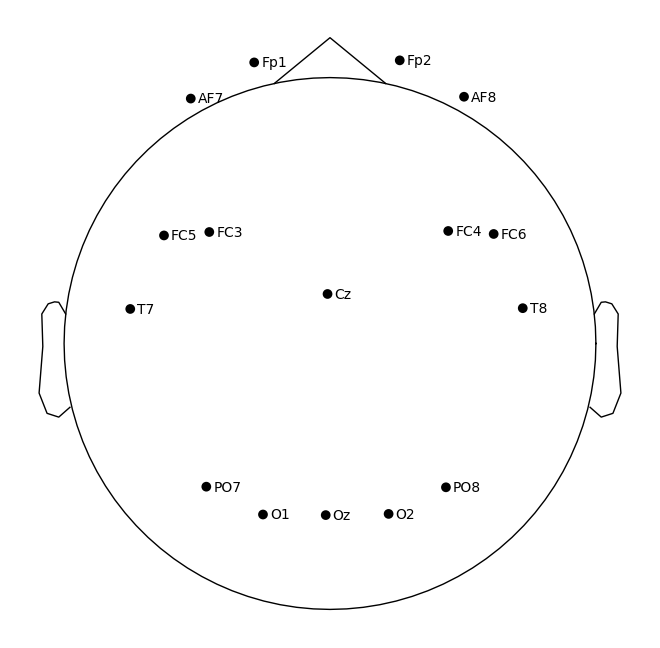

In [6]:
raw.plot_sensors(show_names=True);

### Filtering the data
Highpass filtering is included to remove drifting of the signal, while lowpass filtering will remove power line noise


/opt/homebrew/lib/python3.11/site-packages/mne/viz/utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


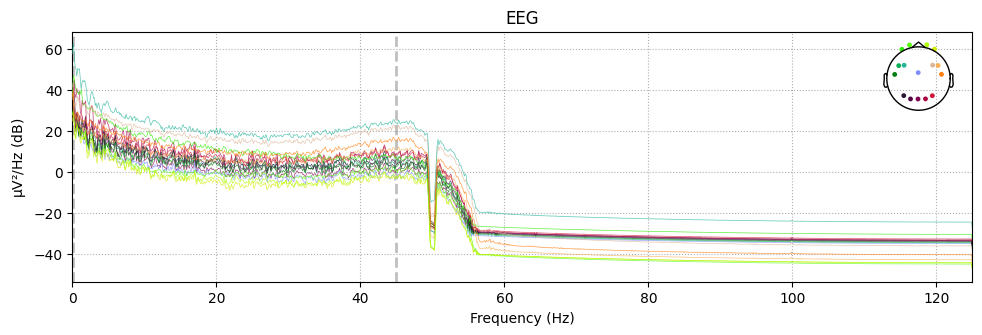

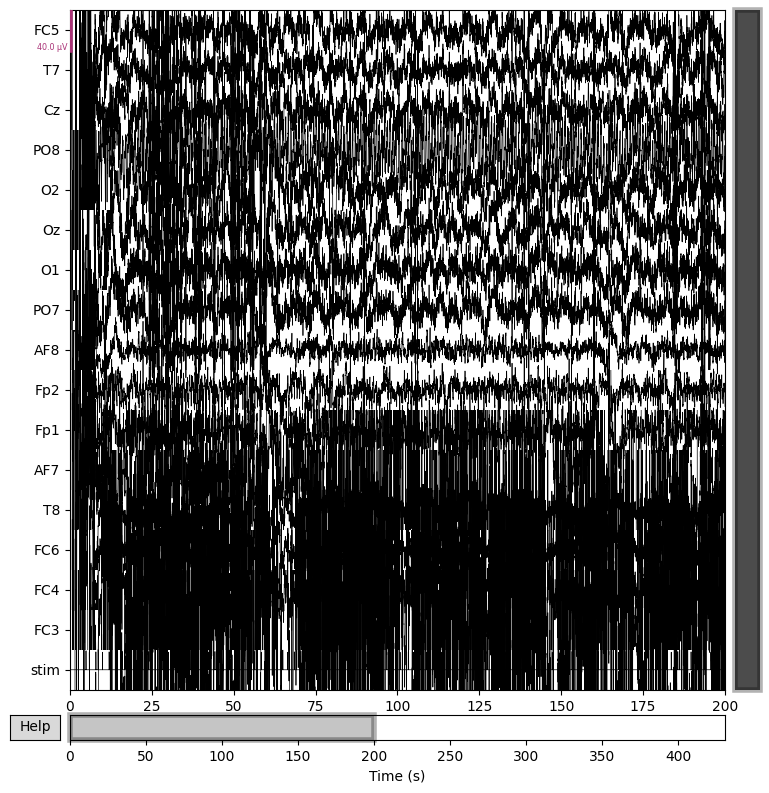

In [7]:
low_cut = 0.1 
hi_cut  = 45
#opt_channels = ['FC5', 'T7', 'Cz', 'PO8', 'AF8','Fp1','AF7','FC6', 'FC4', 'stim']
raw_filt = raw.copy().notch_filter([50], method='iir').filter(low_cut, hi_cut)
raw_postica = ica.apply(raw_filt.copy())
#raw_postica.pick_channels(opt_channels)
raw_postica.compute_psd(fmax=125).plot(picks="data", exclude="bads");
raw_postica.plot(highpass=0.1, lowpass=30, duration=200);

Choose one channel to use for this experiment. Fp2 is one of the frontal electrodes. The data and time is extracted from the filtered raw data, as numpy arrays.

In [8]:
channels = ['PO8', 'Fp1']
picks = mne.pick_channels(ch_names = raw_postica.info['ch_names'], include=channels)
data, time = raw_postica[picks, :]  
print(data)

[[-4.92526465e-08 -9.65165907e-05 -1.98796365e-04 ... -2.62352652e-04
  -1.99211277e-04 -4.92526464e-08]
 [ 1.44782589e-07 -1.23514943e-05 -3.68004110e-05 ... -4.47479061e-05
  -3.39425884e-05  1.44782589e-07]]


The signal is visulaized using matplotlib.

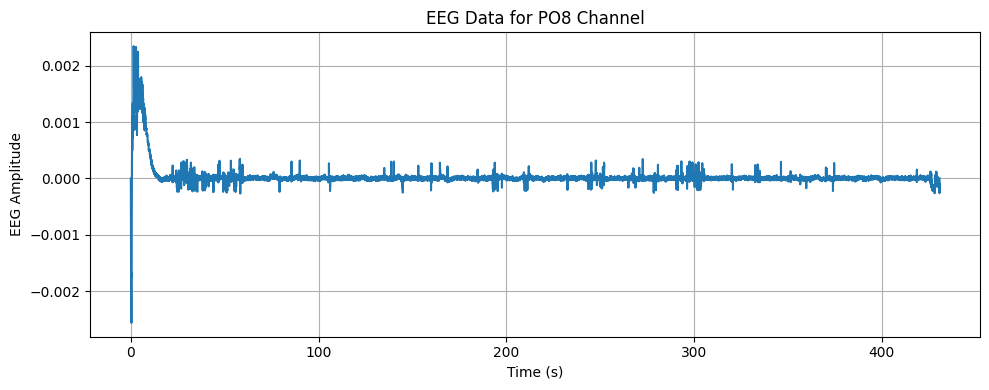

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(time, data[0])
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[0]} Channel')
plt.grid(True)
plt.tight_layout()
plt.show()

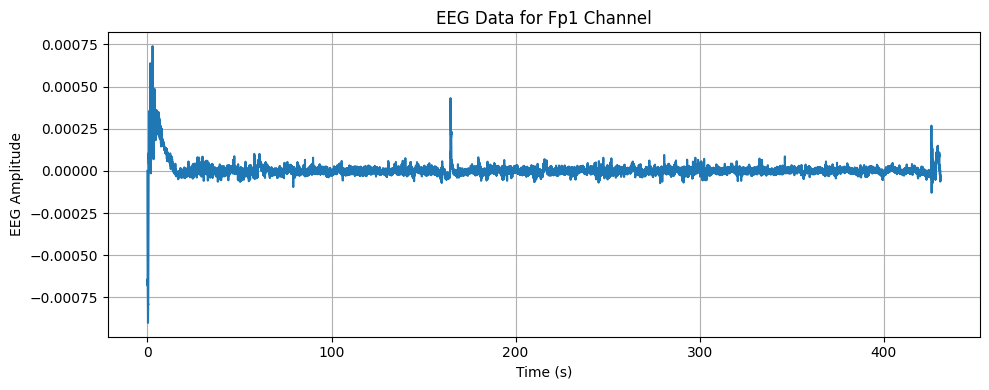

In [10]:
plt.figure(figsize=(10, 4))
plt.plot(time, data[1])
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[1]} Channel')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
sample_rate = raw.info['sfreq']
window_size = 2

s1 = 100
s2 = s1 + window_size

delta1 = int(sample_rate*s1)
delta2 = int(sample_rate*s2)

d0 = data[0][delta1:delta2]
d1 = data[1][delta1:delta2]
t = time[delta1:delta2]
num_samples = len(d0)

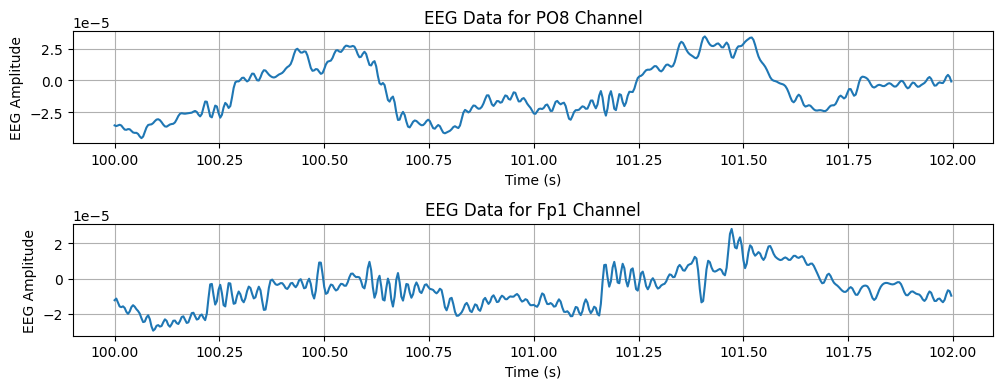

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.plot(t, d0)
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[0]} Channel')
plt.grid(True)

plt.subplot(212)
plt.plot(t, d1)
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[1]} Channel')
plt.grid(True)

plt.tight_layout()
plt.show()

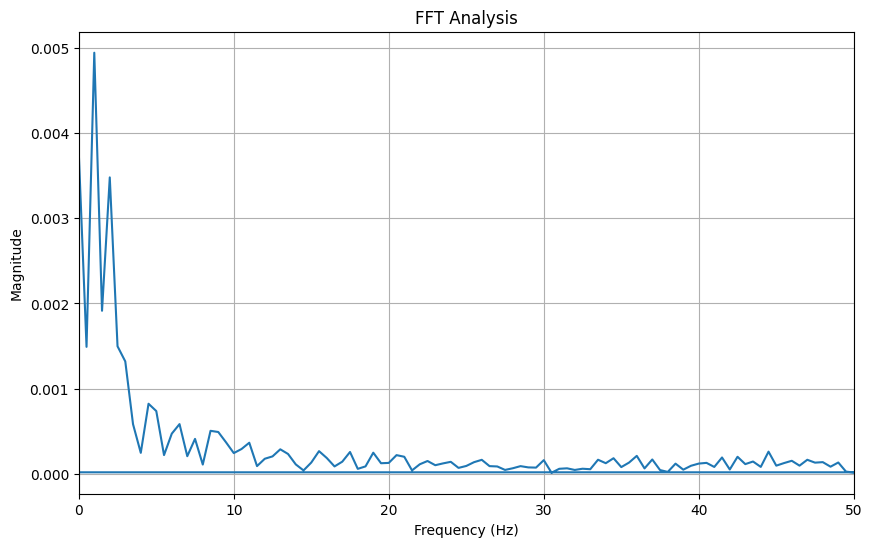

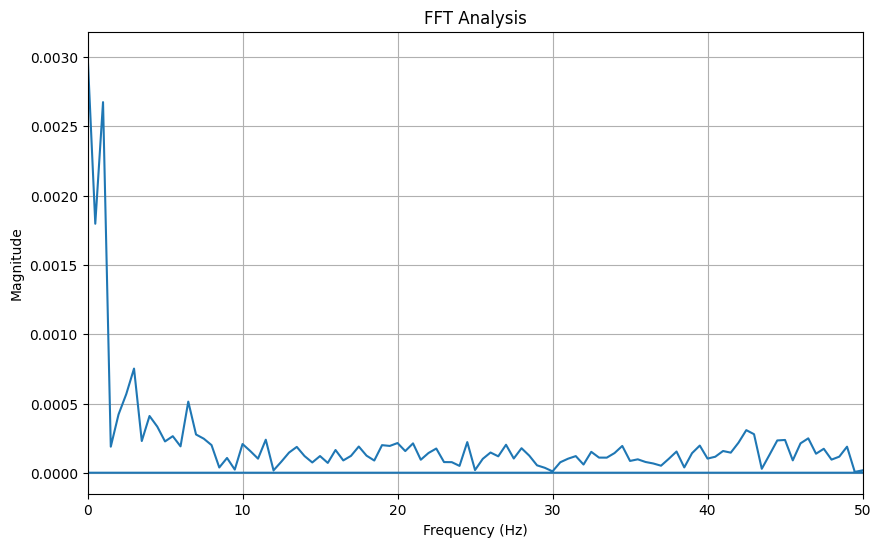

In [13]:
(freq, fft_freq) = fft(d0, num_samples, sample_rate)
(freq, fft_freq) = fft(d1, num_samples, sample_rate)

In [14]:
f, dt, ssx = plot_stft(d0, sample_rate, 50, 5)
f, dt, ssx = plot_stft(d1, sample_rate, 50, 5)


In [15]:
imfs0 = hht(t, d0, plot=False)
imfs1 = hht(t, d1, plot=False)


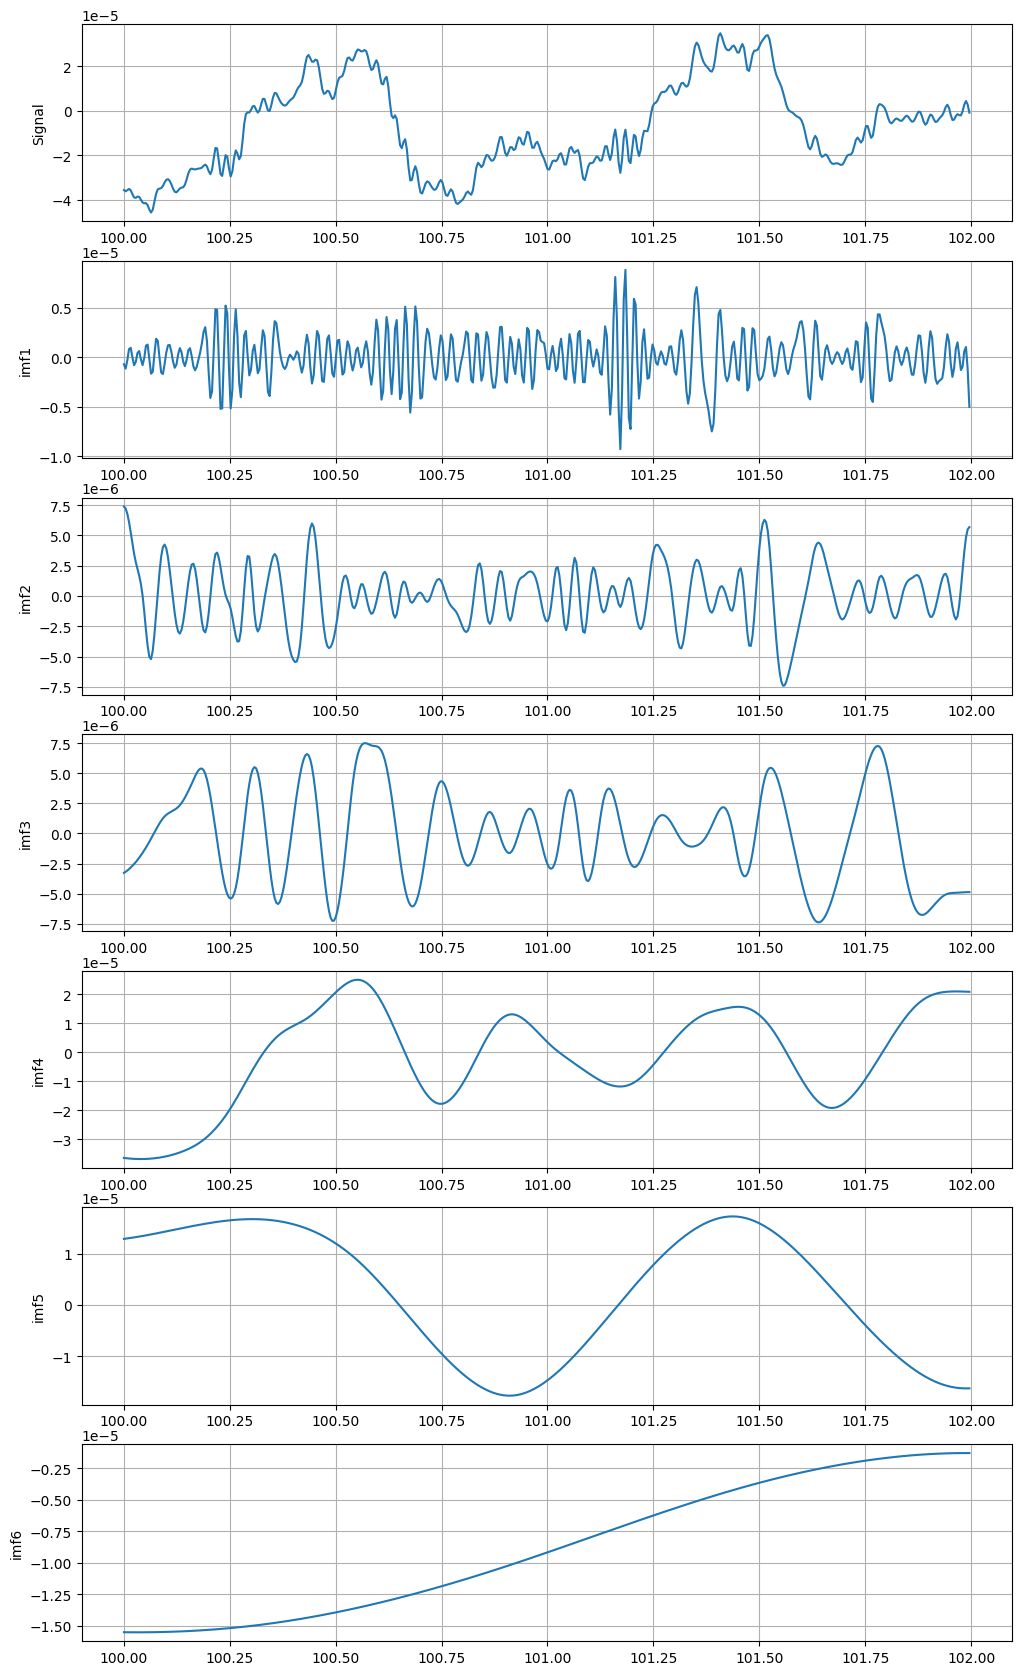

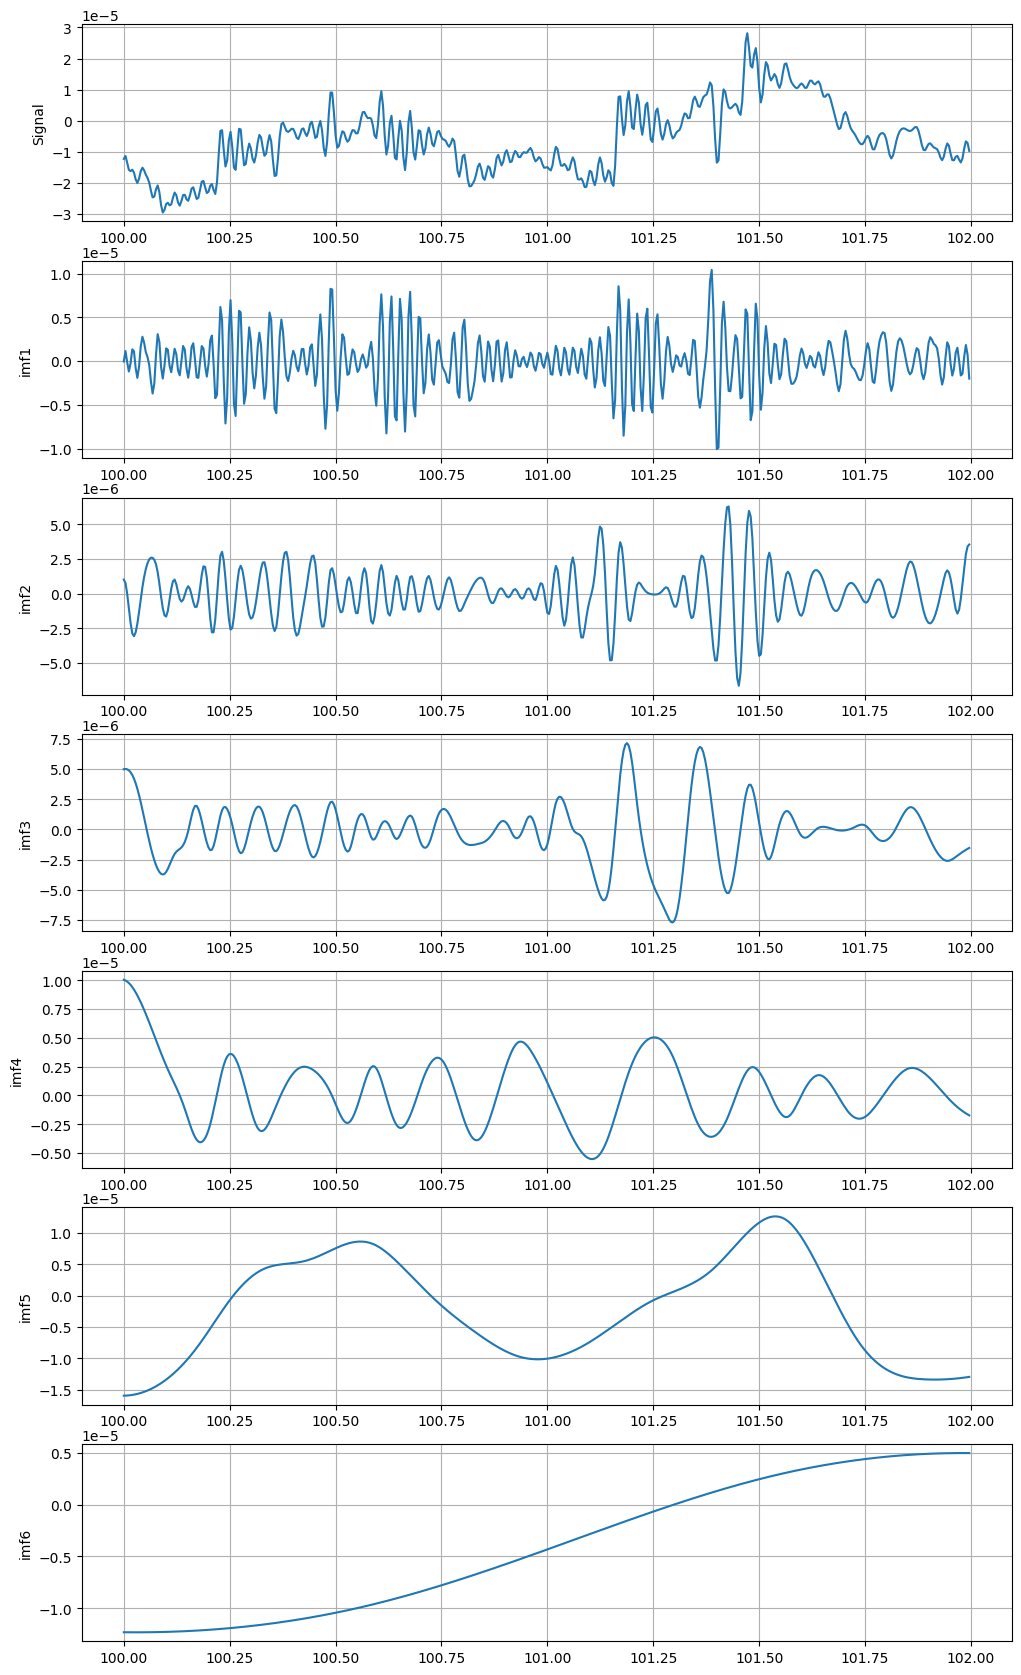

In [16]:
plot_imfs(imfs0, t, d0)
plot_imfs(imfs1, t, d1)

In [17]:
#cwtm = wt(t, d, sample_rate, w=3.0)

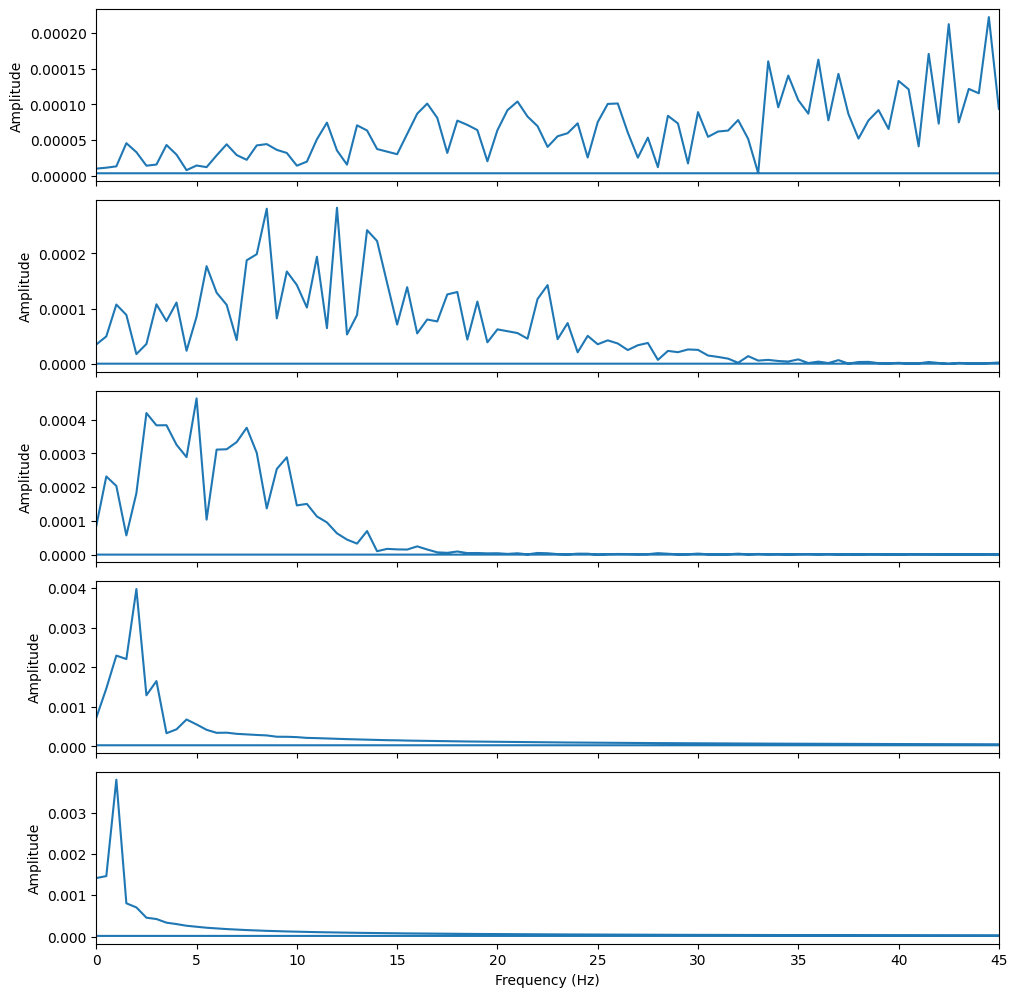

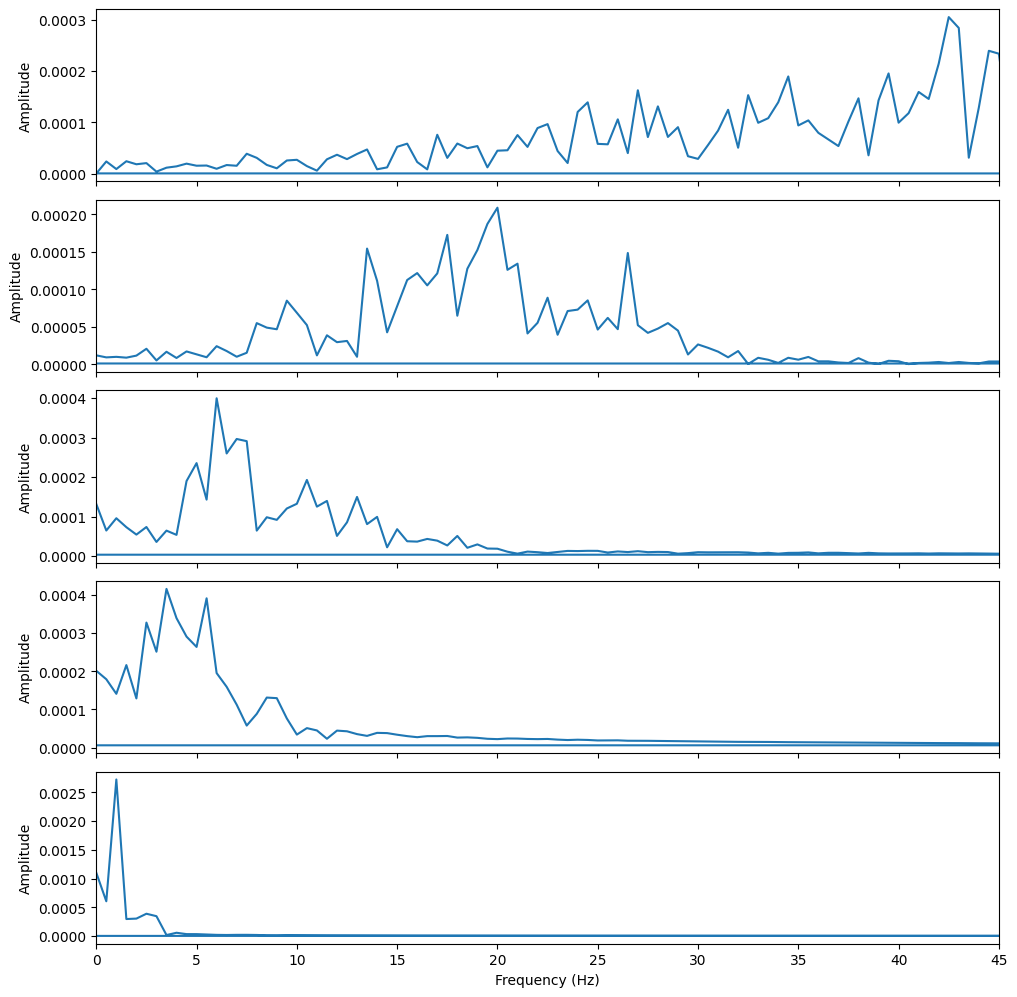

In [18]:
filt_imfs = imfs0[0:len(imfs0)-1]

# Set the figure size dynamically based on the number of IMFs
plt.figure(figsize=(10, 2*len(filt_imfs)))

for idx, imf in enumerate(filt_imfs):
    env, inst_freq = ht(t, imf, sample_rate, plot=False)
    freq, fft_res = fft(imf, num_samples, sample_rate, plot=False)
    
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(freq, fft_res)
    plt.xlim(0, 45)
    
    # If it's not the last subplot, remove the x-axis labels to prevent overlap
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Frequency (Hz)')  # Only add x-axis label to the bottom subplot

    plt.ylabel('Amplitude')

# Adjust the layout to prevent overlapping
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()

filt_imfs = imfs1[0:len(imfs1)-1]

# Set the figure size dynamically based on the number of IMFs
plt.figure(figsize=(10, 2*len(filt_imfs)))

for idx, imf in enumerate(filt_imfs):
    env, inst_freq = ht(t, imf, sample_rate, plot=False)
    freq, fft_res = fft(imf, num_samples, sample_rate, plot=False)
    
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(freq, fft_res)
    plt.xlim(0, 45)
    
    # If it's not the last subplot, remove the x-axis labels to prevent overlap
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Frequency (Hz)')  # Only add x-axis label to the bottom subplot

    plt.ylabel('Amplitude')

# Adjust the layout to prevent overlapping
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()



In [19]:
def plot_stft_imf(imfs, nperseg=200, noverlap=0, ylim_min=0, ylim_max=50):
    filt_imfs = imfs[0:len(imfs) - 1]

    plt.figure(figsize=(12, 4 * len(filt_imfs)))

    # Create subplots
    for idx, imf in enumerate(filt_imfs):
        f, dt, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=nperseg, noverlap=noverlap, plot=False)
        ax = plt.subplot(len(filt_imfs), 1, idx + 1)
        pcm = ax.pcolormesh(dt, f, np.abs(Sxx), shading='gouraud')  # Remove vmin and vmax here
        plt.ylabel('f [Hz]')
        plt.ylim([ylim_min, ylim_max])

        # Calculate the colorbar position
        cbar_x = 1.02  # Adjust this value as needed to position the colorbar correctly
        cbar_width = 0.02
        cbar_height = 0.7 / len(filt_imfs)
        cbar_y = 0.11 + 0.8 * (idx / len(filt_imfs))

        cbar_ax = plt.gcf().add_axes([cbar_x, cbar_y, cbar_width, cbar_height])
        plt.colorbar(pcm, cax=cbar_ax, label='Magnitude [dB]')

    # Add a common xlabel
    plt.xlabel('Time [sec]')
    plt.subplots_adjust(right=0.98)  # Adjust the position of individual colorbars
    plt.show()


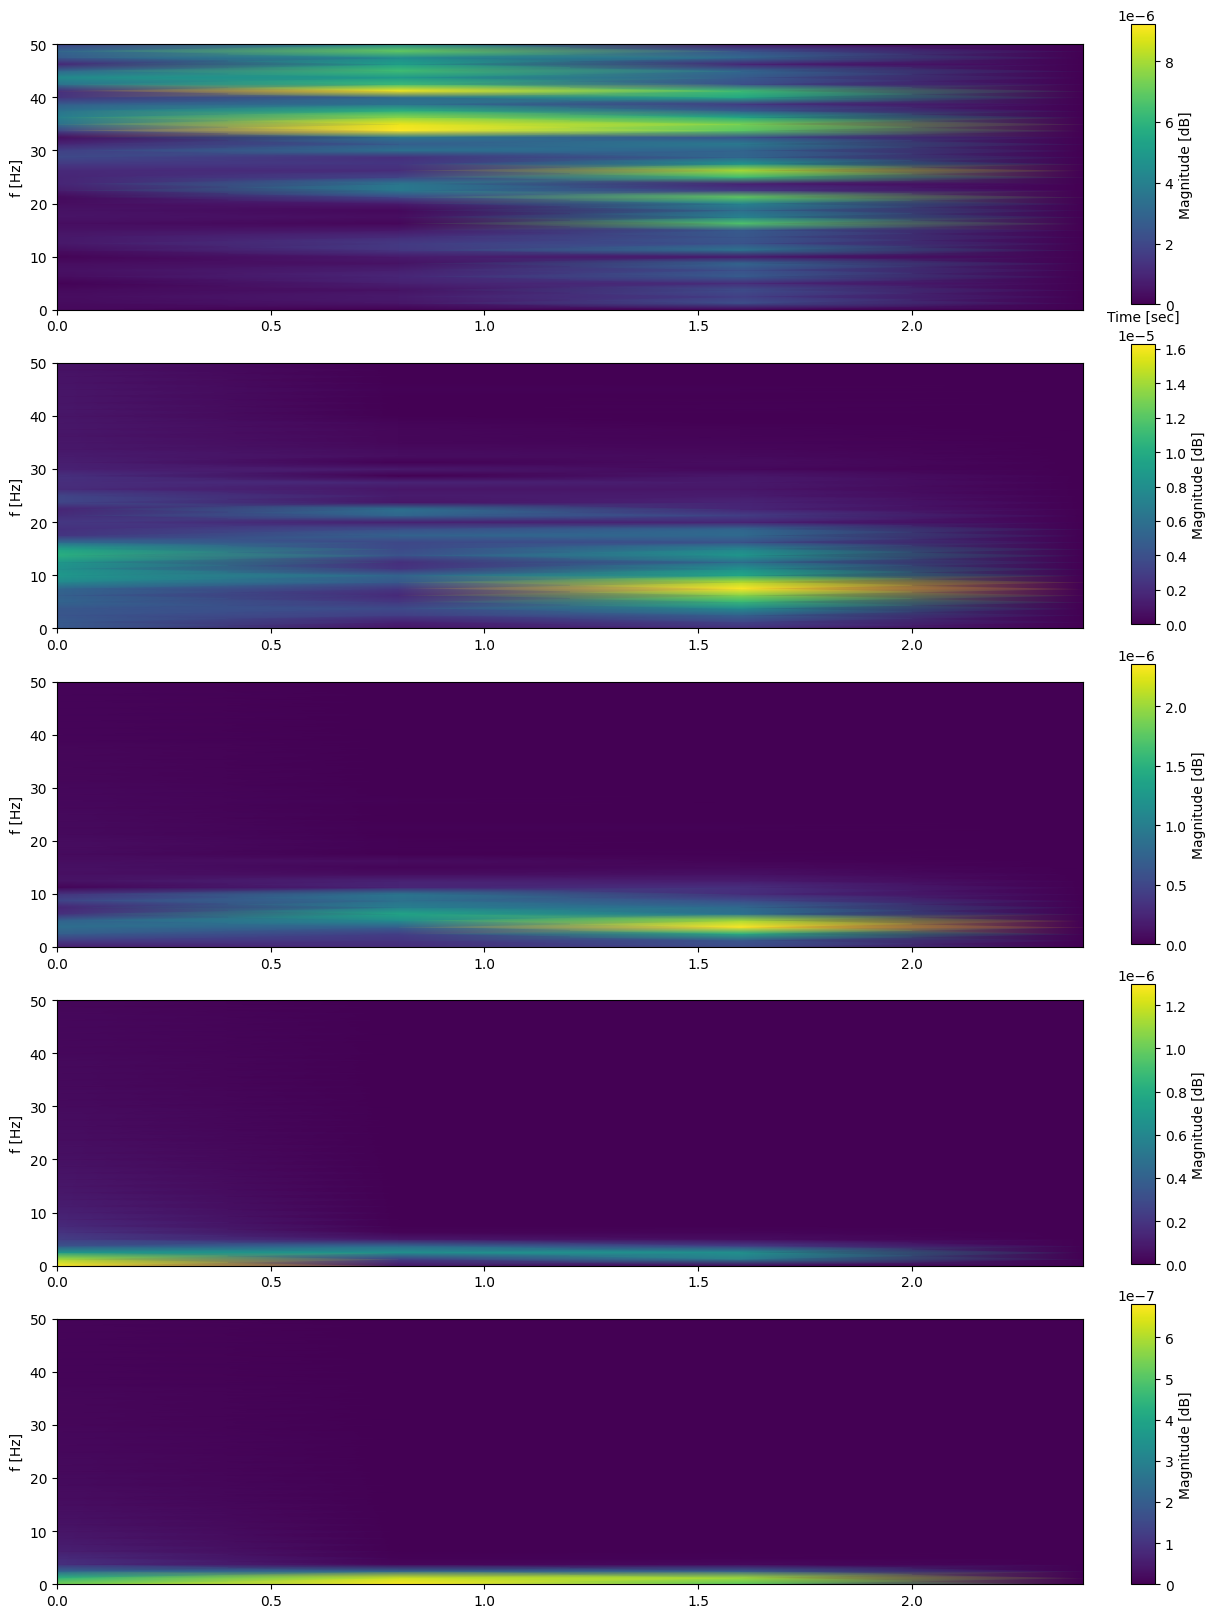

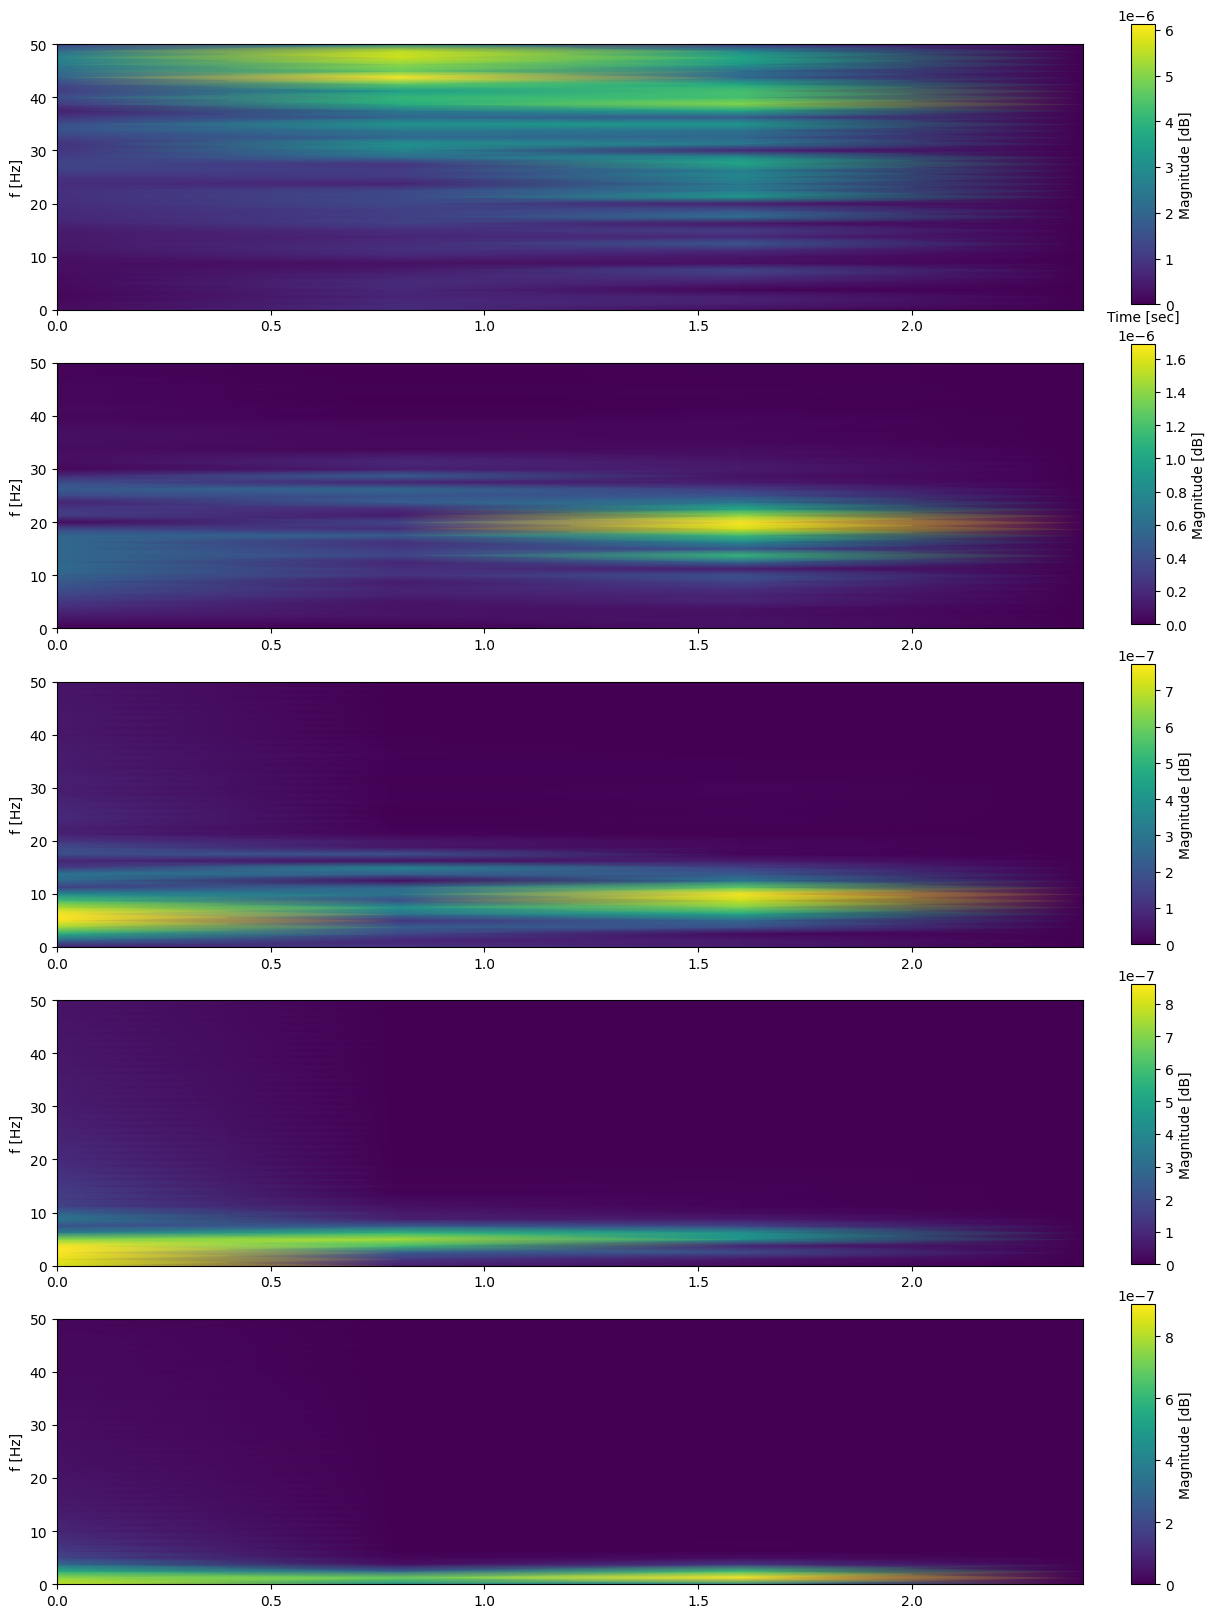

In [20]:
plot_stft_imf(imfs0)
plot_stft_imf(imfs1)

### Plot Wavelet transform

In [21]:
def plot_wavelet_transform_imf(imfs, t, sample_rate, ylim_min=0, ylim_max=50):
    filt_imfs = imfs[0:len(imfs)-1]

    plt.figure(figsize=(16, 4*len(filt_imfs)))
    # Create subplots and apply the same vmin and vmax to each
    for idx, imf in enumerate(filt_imfs):
        cwtm = wt(t, imf, sample_rate, w=6.0)
        ax = plt.subplot(len(filt_imfs), 1, idx+1)
        freq = np.linspace(1, sample_rate/2, 100)
        plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
        if idx < len(filt_imfs) - 1:
            ax.set_xticklabels([])
        else:
            plt.xlabel('Time [s]')  # Only add x-axis label to the bottom subplot
        plt.ylabel('Amplitude')
        plt.ylim([ylim_min, ylim_max])
    plt.show()

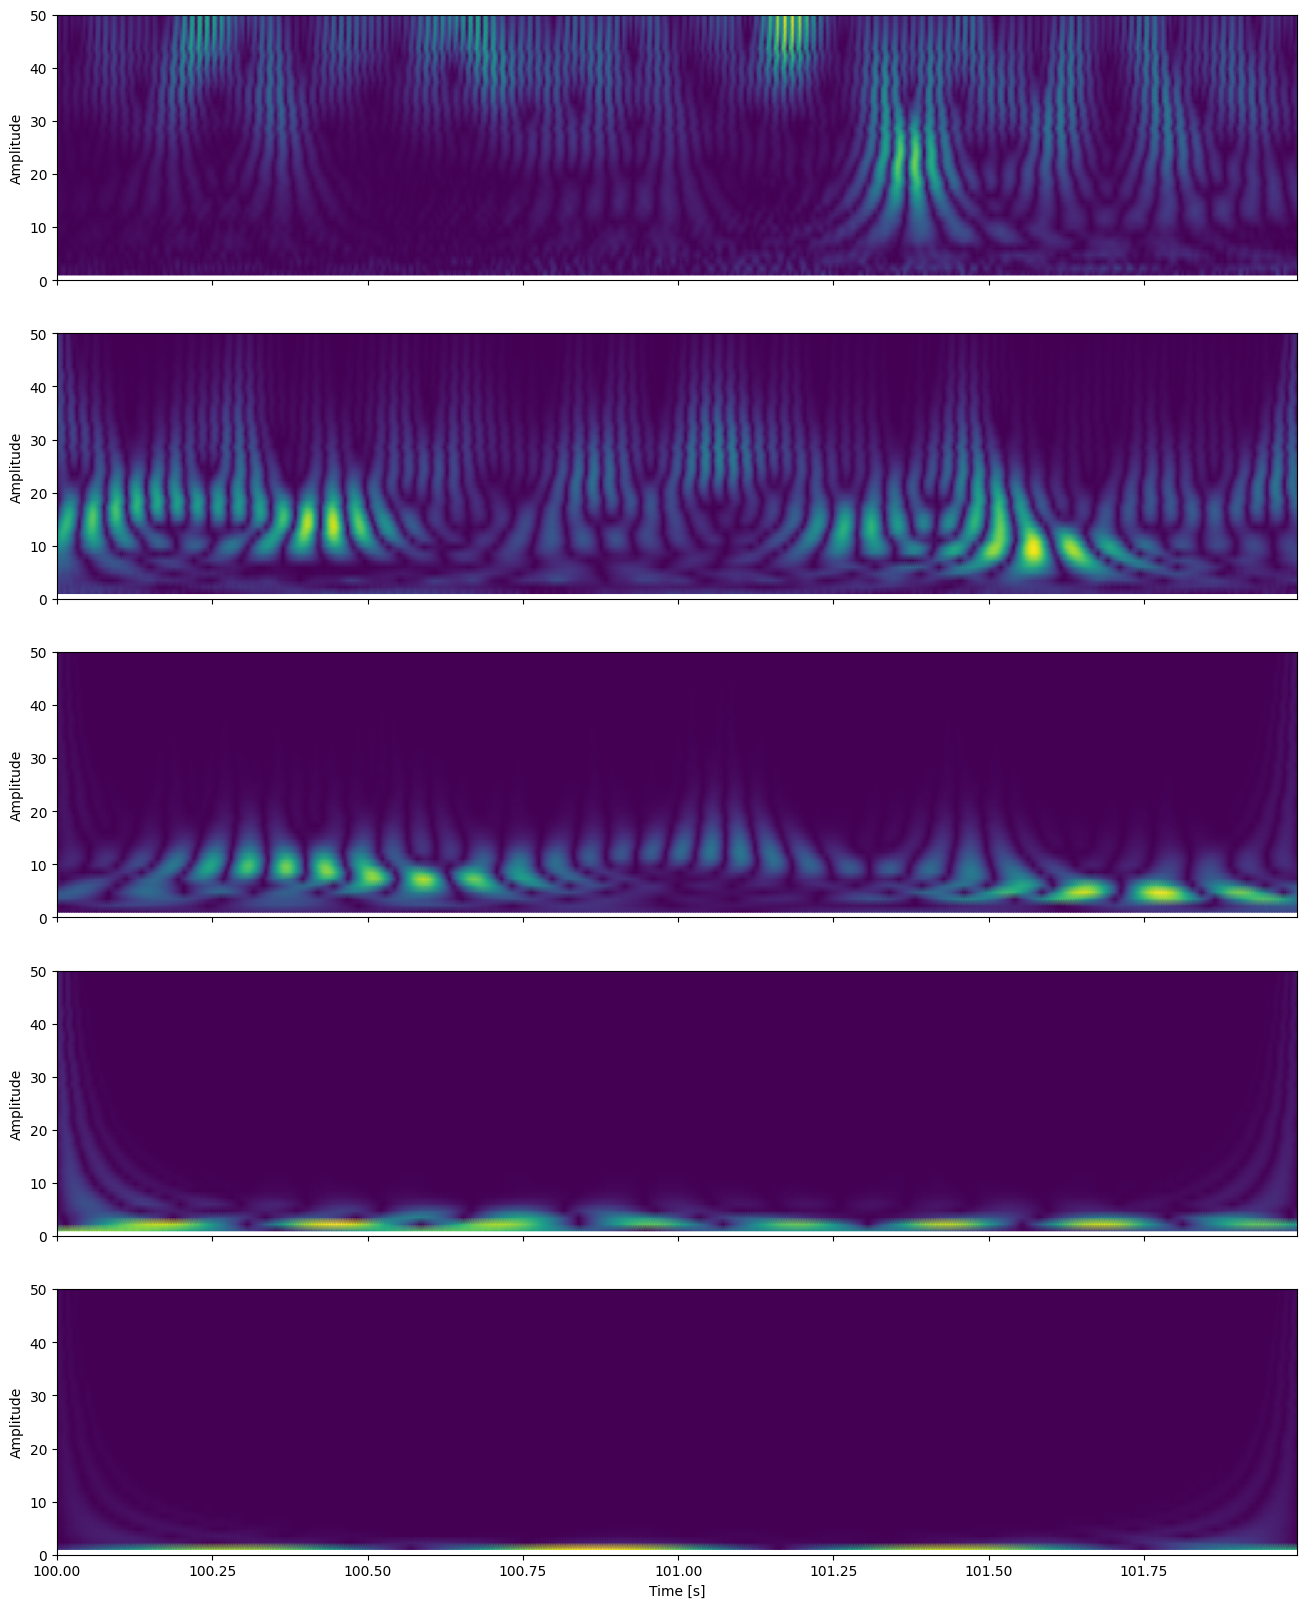

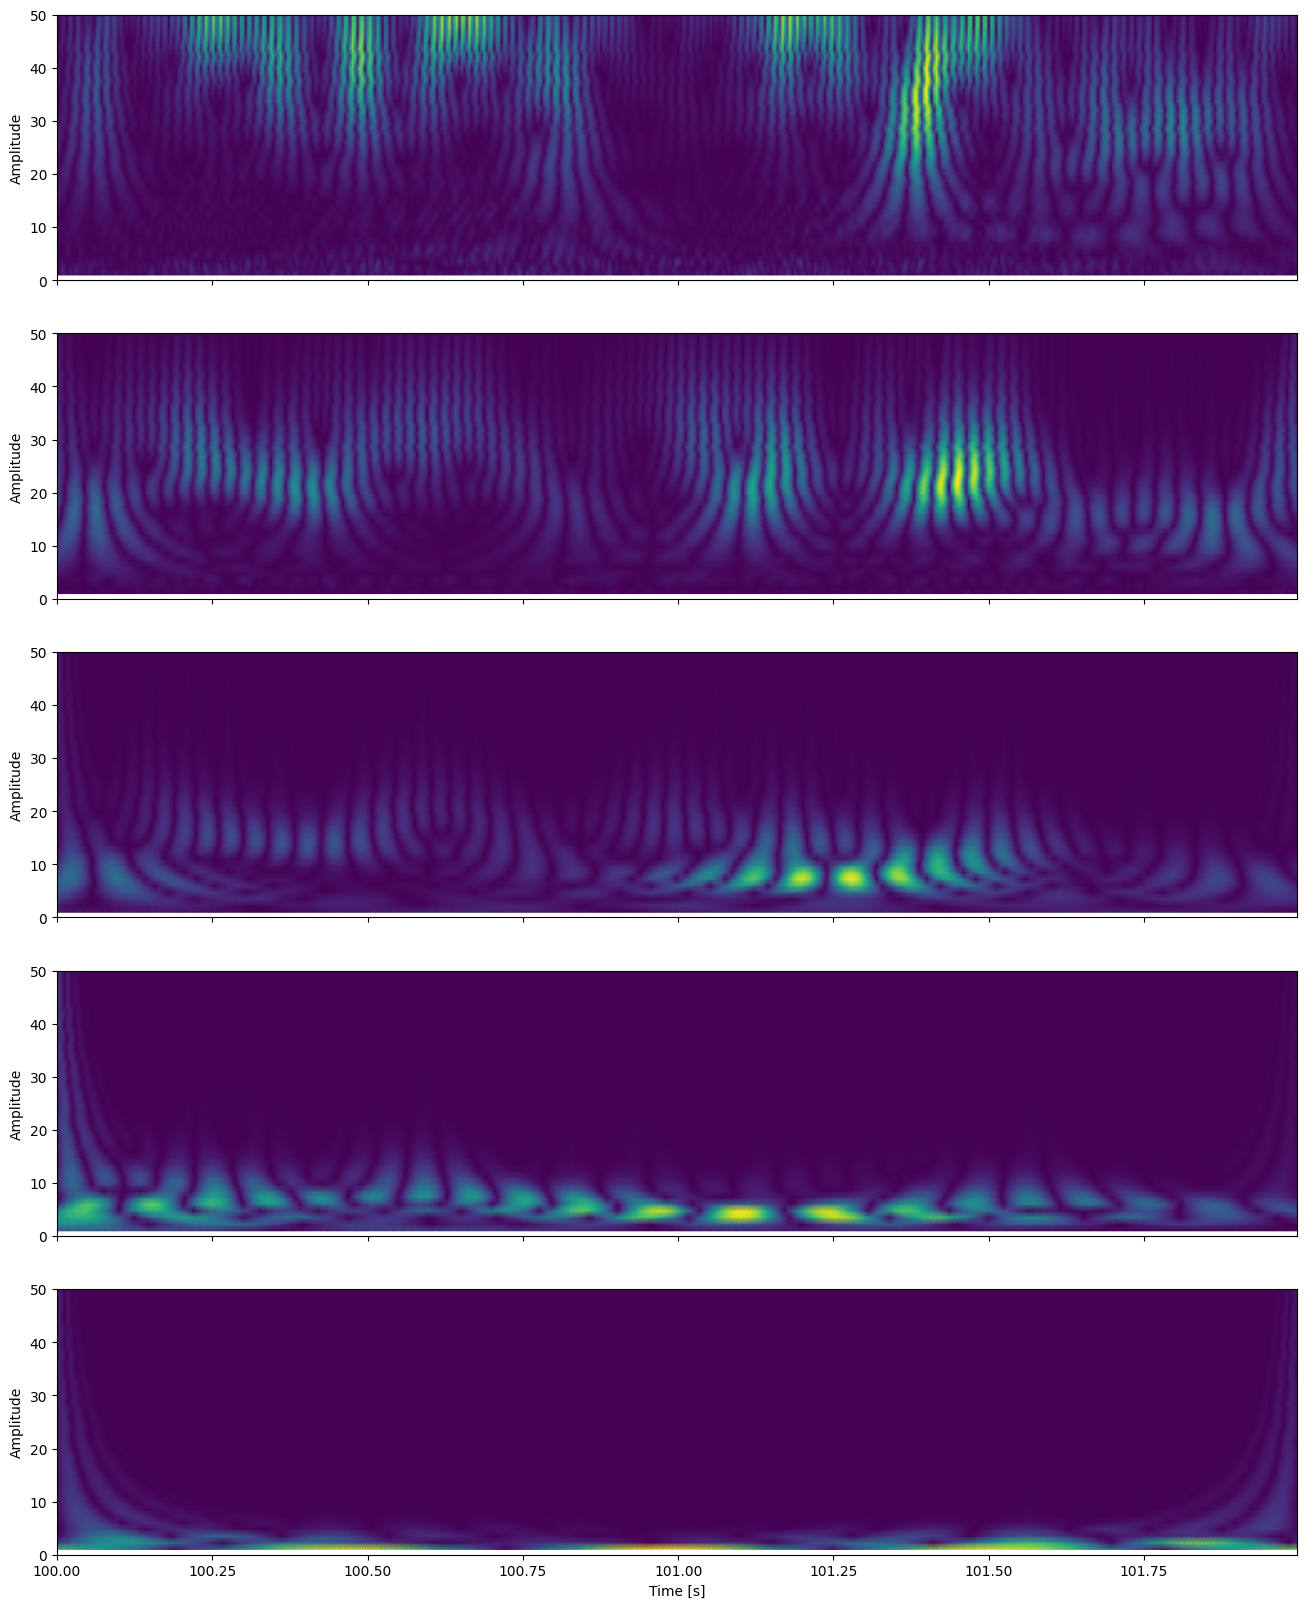

In [22]:
plot_wavelet_transform_imf(imfs0, t, sample_rate)
plot_wavelet_transform_imf(imfs1, t, sample_rate)

### Plot Hilbert Transform

In [23]:
def plot_hilbert_transform_imf(imfs, t, sample_rate, plot_envelope=True, plot_frequency=True):
    filt_imfs = imfs[0:len(imfs)-1]

    envelopes = []
    frequencies = []
    for idx, imf in enumerate(filt_imfs):
        amplitude_envelope, instantaneous_frequency = ht(t, imf, sample_rate, plot=False)
        envelopes.append(amplitude_envelope)
        frequencies.append(instantaneous_frequency)

    if plot_envelope:
        plt.figure(figsize=(16, 3*len(filt_imfs)))
        for idx, envelope in enumerate(envelopes):
            ax = plt.subplot(len(filt_imfs), 1, idx+1)
            plt.plot(t, filt_imfs[idx], label=f'IMF {idx}')
            plt.plot(t, envelope)    
            if idx < len(filt_imfs) - 1:
                ax.set_xticklabels([])
            else:
                plt.xlabel('Time [s]')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.subplots_adjust(bottom=0.06)
        plt.show()

    if plot_frequency:
        plt.figure(figsize=(16, 3*len(filt_imfs)))
        for idx, frequency in enumerate(frequencies):
            ax = plt.subplot(len(filt_imfs), 1, idx+1)
            plt.plot(t[1:], frequency, label=f'IMF {idx}')    
            if idx < len(filt_imfs) - 1:
                ax.set_xticklabels([])
            else:
                plt.xlabel('Time [s]')
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.subplots_adjust(bottom=0.06)
        plt.show()

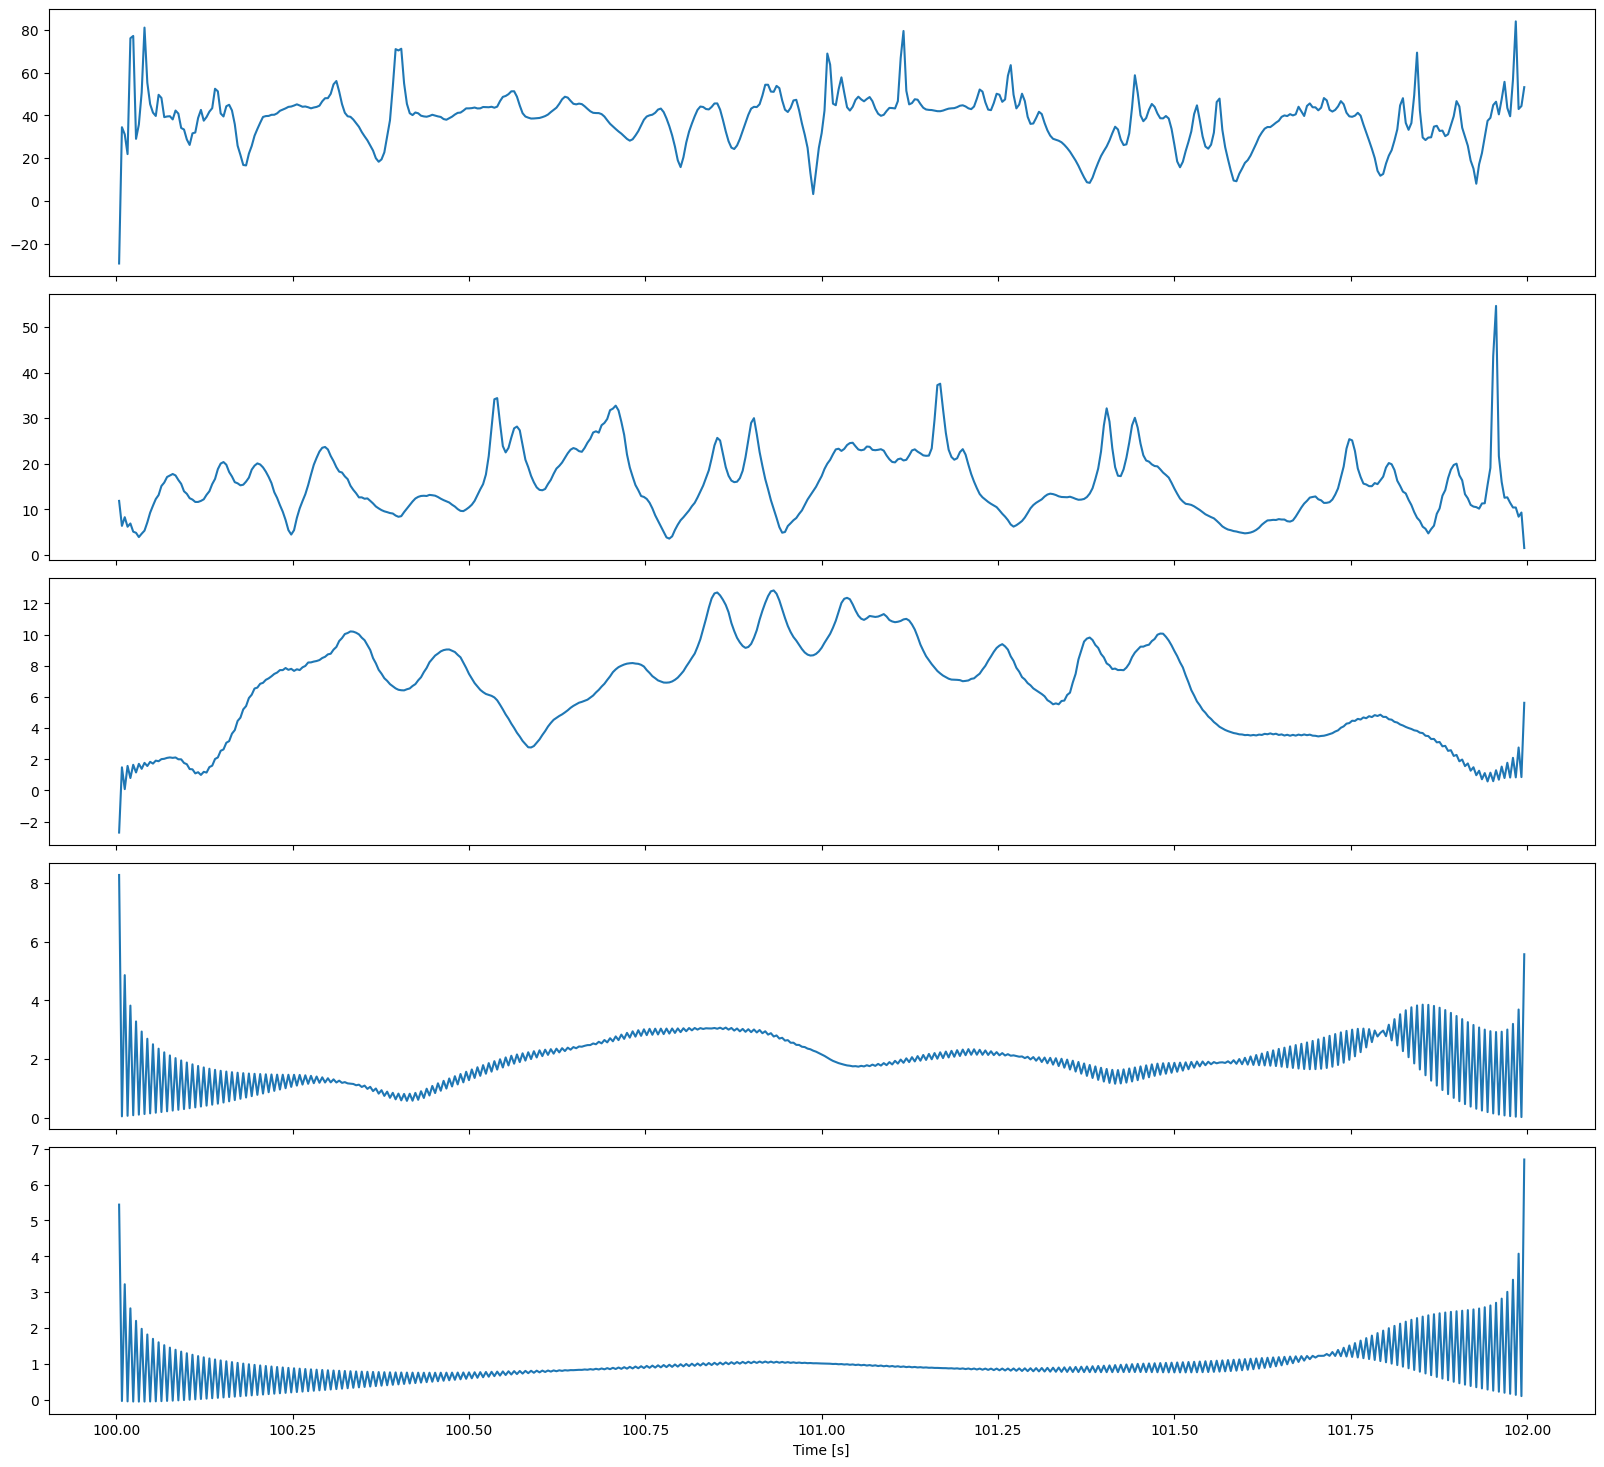

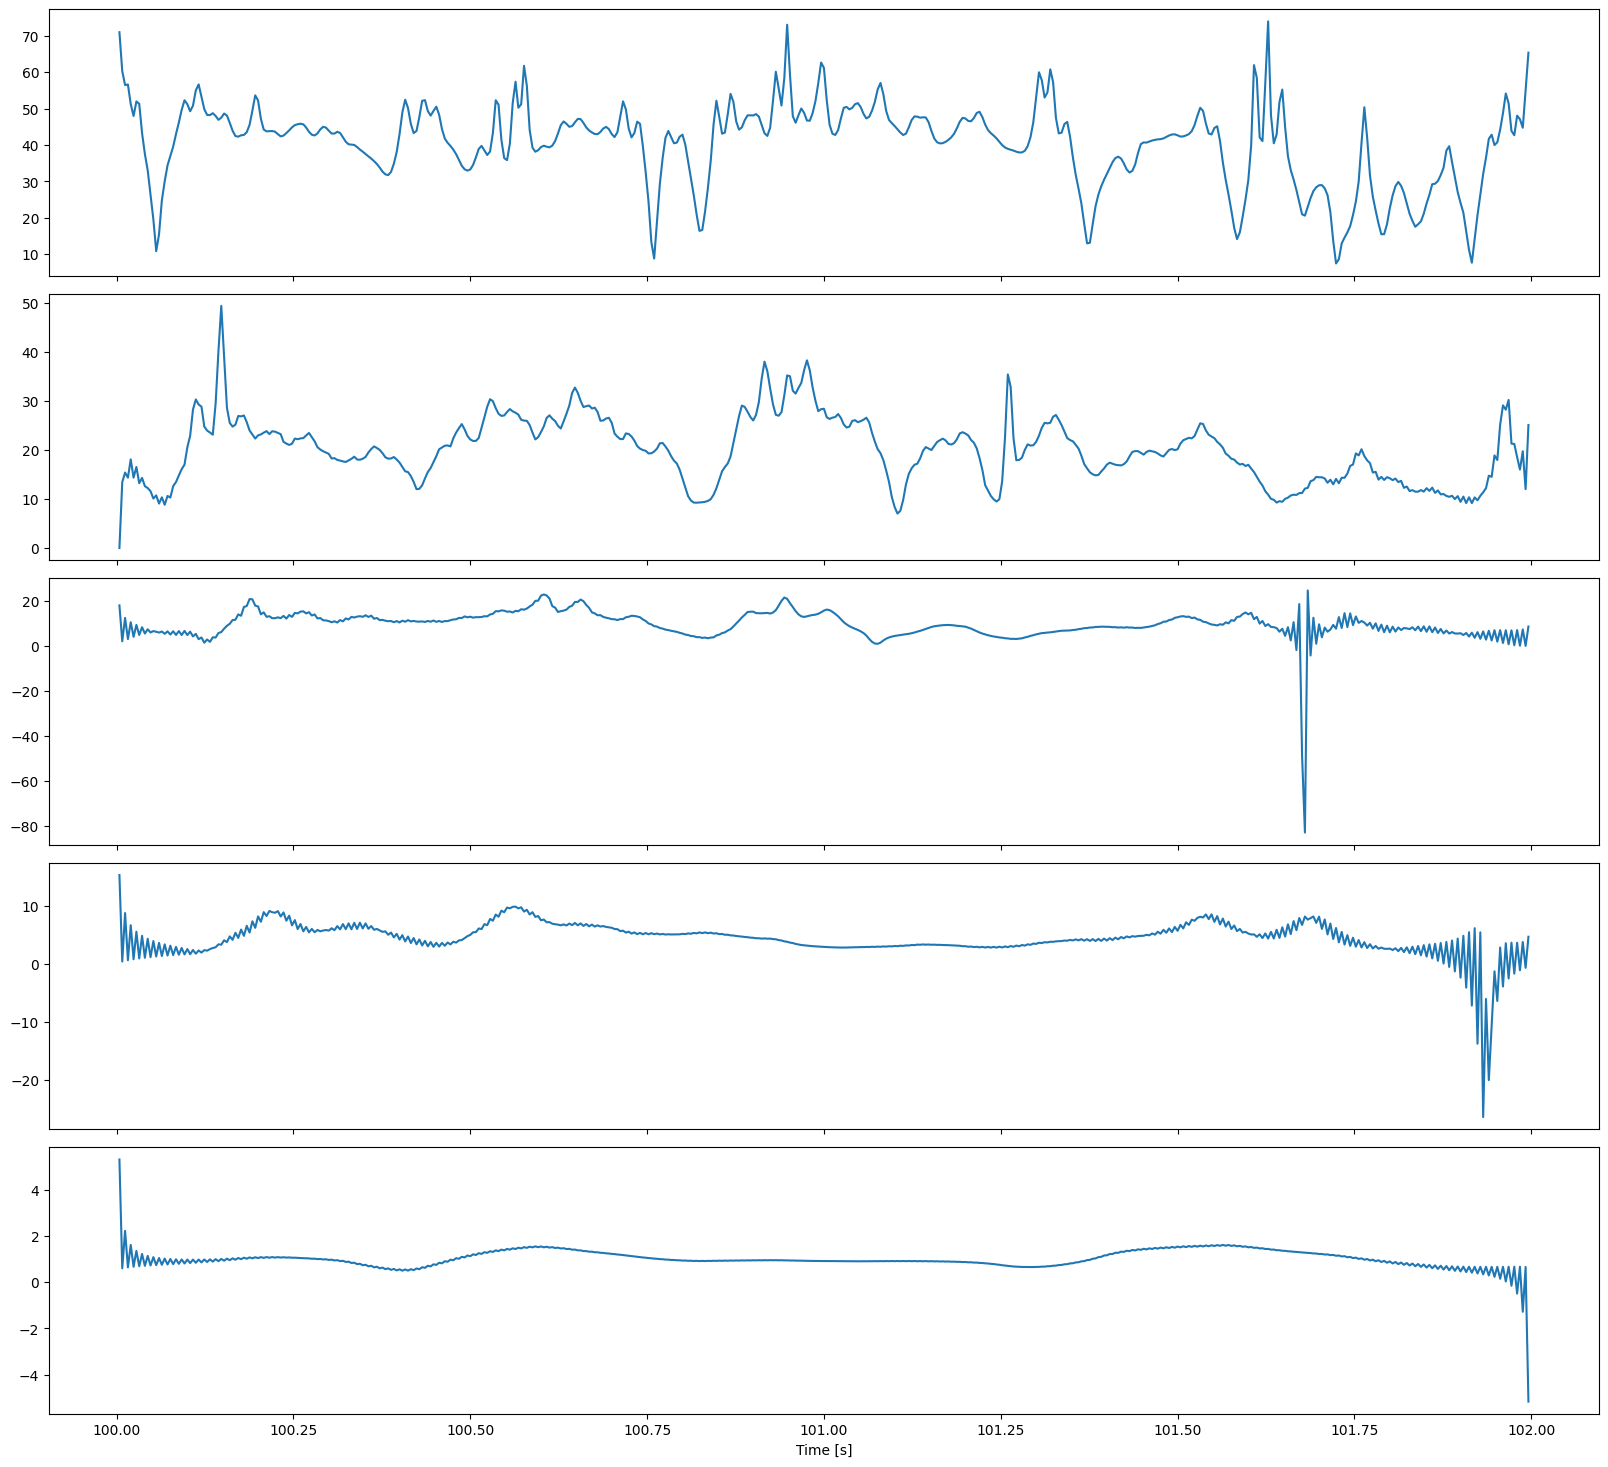

In [24]:
plot_hilbert_transform_imf(imfs0, t, sample_rate, plot_envelope=False)
plot_hilbert_transform_imf(imfs1, t, sample_rate, plot_envelope=False)